In [679]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [687]:
class Activation:
    def __init__(self, activation_function, activation_derivative):
        self.calc = activation_function
        self.der = activation_derivative

In [688]:
def softmax_calculate(X):  
    #calculate the value of the linear multiplication with normalization:
    max_col = np.max(X, axis=1).reshape(-1,1)
    norm = X - max_col
    #compute the softmax function:
    norm_exp = np.exp(norm)
    softmax = norm_exp / np.sum(norm_exp, axis=1).reshape(-1,1)
    return softmax

def softmax_regression_loss(X, Y, W, b):

    num_samples = Y.shape[1]

    #calculate the value of the linear multiplication with normalization:
    linear_calc = np.dot(X.T, W) + b.reshape(1,-1)
    max_col = np.max(linear_calc, axis=1).reshape(-1,1)

    linear_norm = linear_calc - max_col
    #compute the softmax function:
    linear_norm_exp = np.exp(linear_norm)

    softmax = linear_norm_exp / np.sum(linear_norm_exp, axis=1).reshape(-1,1)


    #compute loss:
    log_softmax = np.log(softmax)
    #replace loss_unnorm with a vector with each entry being the inner multiplication of each column of Y with the corresponding column of log_softmax:
    loss_unnorm = Y*log_softmax.T
    loss = -np.sum(np.sum(loss_unnorm, axis=0)) / num_samples

    #compute gradients:
    dsoftmax = softmax - Y.T
    dw = np.dot(X, dsoftmax) / num_samples
    db = np.sum(dsoftmax) / num_samples
    

    #gradient w.t.r to X:
    dx = np.dot(W, softmax.T - Y) / num_samples


    return loss, dw, db, dx




softmax_activation = Activation(softmax_calculate, softmax_regression_loss)


In [689]:
def tanh_calculate(X):
    return np.tanh(X)

def tanh_derive(X):
    return 1 - np.tanh(X)**2


tanh_activation = Activation(tanh_calculate, tanh_derive)


In [690]:
class Layer:
    def __init__(self, input_dim, output_dim, activation):
        self.W = np.random.rand(output_dim, input_dim)
        self.b = np.random.rand(output_dim,1)
        self.activation = activation
        self.X = None
        self.Y = None
        self.dW = None
        self.db = None
        self.dX = None

    def forward(self, X):
        self.X = X
        self.linear_calc = np.dot(self.W, self.X) + self.b
        self.Y = self.activation.calc(self.linear_calc)
        return self.Y

    def backward(self, dY):
        self.db = dY * self.activation.der(self.linear_calc)
        self.dW = np.dot(self.db, self.X.T)
        self.dX = np.dot(self.W.T, self.db)
        return self.dX

    def update(self, alpha):
        self.W -= alpha*self.dW
        self.b -= alpha*self.db


In [691]:
class LossLayer(Layer):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim, output_dim, softmax_activation)
        self.loss = None
        self.W = self.W.T
        self.b = self.b.T
    
    def forward(self, X):
        self.X = X

    def backward(self, Y):
        self.loss, self.dW, self.db, self.dX = self.activation.der(self.X, Y, self.W, self.b)
        return self.dX


In [692]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, dY):
        for layer in reversed(self.layers):
            dY = layer.backward(dY)

    def update(self, alpha):
        for layer in self.layers:
            layer.update(alpha)
    
    def get_network_loss_and_dx(self, X, Y):
        self.forward(X)
        self.backward(Y)
        dX = self.layers[0].dX
        loss = self.layers[-1].loss
        return loss, dX
    
    def grad_verify(self):
        input_features = self.layers[0].W.shape[1]
        classes = self.layers[-1].b.shape[1]
        X = np.random.rand(input_features, 8)
        Y = np.zeros((classes, 8))
        Y[np.random.randint(0, classes)] = 1
        epsilons = np.array([(0.5)**i for i in range(1, 10)])
        d = np.random.rand(input_features, 1)
        losses_ord1 = []
        losses_ord2 = []
        epsd_grads = []
        for epsilon in epsilons:
            eps_d = epsilon*d
            X_plus = X.copy() + eps_d
            loss_plus, _ = self.get_network_loss_and_dx(X_plus, Y)
            loss, dx = self.get_network_loss_and_dx(X, Y)
            #first order:
            loss_ord1 = loss_plus - loss
            loss_ord1_abs = np.abs(loss_ord1)
            epsd_grad = np.sum(np.multiply(eps_d, dx))
            #second order:
            loss_ord2  = loss_ord1 - epsd_grad
            loss_ord2_abs = np.abs(loss_ord2)
            losses_ord1.append(loss_ord1_abs)
            losses_ord2.append(loss_ord2_abs)
            epsd_grads.append(epsd_grad)
        return epsilons, losses_ord1, losses_ord2, epsd_grads
    
    def grad_visualizer(self):
        epsilons, losses_ord1, losses_ord2, eps_grad = self.grad_verify()
        epsilons_sorted = np.sort(epsilons)
        plt.plot(epsilons_sorted, eps_grad, label='epsd - O(\u03B5)')
        plt.plot(epsilons_sorted, losses_ord1, label='First Order - O(\u03B5)')
        plt.plot(epsilons_sorted, losses_ord2, label='Second Order - O(\u03B5^2)')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Epsilon')
        plt.ylabel('Loss')
        plt.title('Gradient Verification - Log Scale')
        plt.legend()
        plt.show()

    def sgd(self, X, Y, alpha=0.1, num_iterations=10000):
        losses = []
        for i in range(num_iterations):
            self.forward(X)
            self.backward(Y)
            self.update(alpha)
            losses.append(self.layers[-1].loss)
        return losses

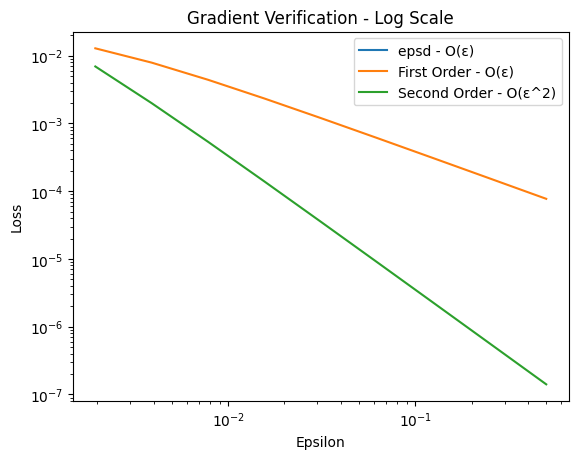

In [693]:
# initialize a network for grad verification:
input_dim = 3
hidden_dim = 2
output_dim = 5
layer1 = Layer(input_dim, hidden_dim, tanh_activation)
loss_layer = LossLayer(hidden_dim, output_dim)
network = NeuralNetwork([layer1, loss_layer])
network.grad_visualizer()